# gpsMSSA
##Test ability of mssa to seperate signals in time series

The code used for this experiment can be found on USF gituhub site: https://github.com/USFgeodesy/gpsMSSA.git

Based on:

[Walwer, Damian, Eric Calais, and Michael Ghil. "Data‐Adaptive Detection of Transient Deformation in Geodetic Networks." Journal of Geophysical Research: Solid Earth (2016).](http://onlinelibrary.wiley.com/doi/10.1002/2015JB012424/pdf)

We will start with synthetic data using a SSE like transient with random white noise, we will also include both seasonal and semi-annual signals:

First we create a series of data channels (6) with the same transient and random noise...


In [1]:
#import relevent libraries
import numpy as np
import pandas as pd
from gpsMSSA import ssa,syn_data,mssa,gpsUtils
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:

#function for making a data frame of synthetic data with white noise added 
from scipy import stats
def make_syn_df(times,funlist,numChannels):
    '''
    generate synthetic time series
    '''
    x = syn_data.model_tseries(times,funlist)
    columns = ['C'+str(i) for i in range(numChannels)]
    data = np.zeros((len(times),numChannels))
    for i in range(numChannels):
        noise = np.random.normal(0,2,len(times))
        data[:,i] = np.add(x,noise)
        data[:,i] = data[:,i]-np.mean(data[:,i])
    df = pd.DataFrame(data,index=times,columns=columns)
    return df

We will generate our synthetic data here using a 10 year long time series with daily observations with 6 data streams. Model Paramaters are:

1. SSE with duration of 100 days and amplitude of 5 centered on 2011.3
2. Seasonal signal with a sine wave amplitude 0.7 and cosine amplitude 1.1
3. Semi-Annual signal with sine amplitude 0.5 and cosine amplitude 0.8

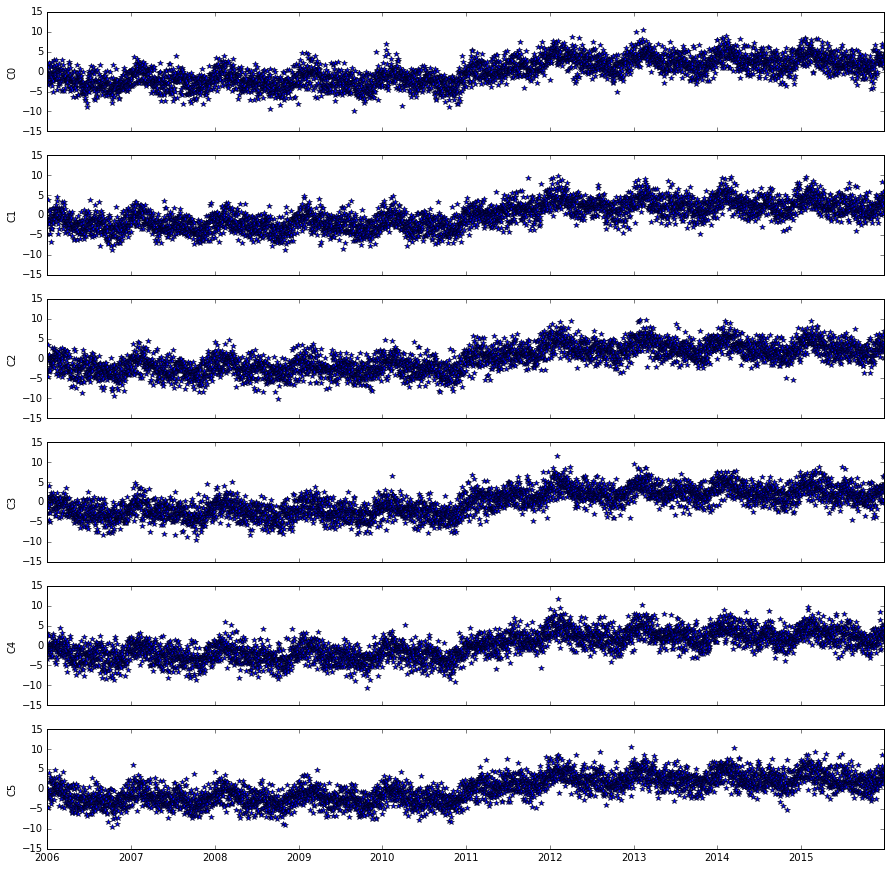

In [3]:
#time series from 2012 to 2016
times = np.arange(2006.0,2016.0,(1/365.25))

fun = 'syn_data.sse' #arctan function
args = [0,2011.3,100.0,5.0] #sse has a midpoint of 2014.0, a duration of 40 days and amplitude of 3
fun2 = 'syn_data.periodAnn'
args2 = [0,0,0.7,1.1]
fun3 = 'syn_data.periodSemiAnn'
args3 = [0,0,0.5,0.8]
funList = []
funList.append(eval(fun)(*args))
funList.append(eval(fun2)(*args2))
funList.append(eval(fun3)(*args3))
sse = syn_data.model_tseries(times,[eval(fun)(*args)])
sse = sse-np.mean(sse)
seas = syn_data.model_tseries(times,[eval(fun2)(*args2),eval(fun3)(*args3)])

df = make_syn_df(times,funList,6) #6 is the number of channels
f, ax = plt.subplots(len(df.columns), sharex=True, sharey=True,figsize=(15,15) )
for i,c in enumerate(df.columns):
    ax[i].plot([gpsUtils.decimal2datetime(d) for d in times],df[c],'*')
    ax[i].set_ylabel(df.columns[i])

So now we have 6 channels of data (could think of it as 2 gps stations), with random noise (gaussian with std = 2.0 added to the signal. 

The critical step for MSSA is choice of Lag window M. M should be large enough to caputure the maximum period of the signal of interest. In our case 1 year annual signal so it should be bigger than 365. However, with larger lags we will bleed signals into multiple components. Such that a single signal will need multiple PC in order to be fully described. 

We will use a time window of 400 days in order to be consistant with the paper. 

In this case I am using an implementation of the Broomhead-King type covariance matrix. I have tried to impliment an fft based Covariance matrix which should be much faster for long time lags, but so far it has an untractable bug 


In [4]:
M =400
c = mssa.bk(df,400)

Next we get the eigenvectors and eigenvalues from the Lagged covariance matrix

In [5]:
rho,lamb = mssa.get_eigen(c)

One odd thing is that becuase we are using an approximation the covariance matrix we get a few negative eigenvalues which is not strictly proper. However, they seem to be small (not account for much variance) and it is a problem ofte nfound when the covariance matrix gets large (Large M and many channels) 

In [6]:
print min(lamb)

0.075169588323


We can look at the Ranked Percent variance explained of the eigenvalues to look how much information is associated with each...

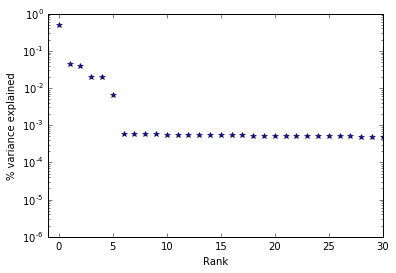

In [7]:
plot(lamb/np.sum(lamb),'*')
xlim(-1,30)
xlabel('Rank')
yscale('log')
ylabel('% variance explained')

We can see that almost all the variance is explained by the first eigenvalue, and that most of the data can be explained using only the first 6 eignvalues or PCs. Another interesting factor is the pairs of eignvalues, in this case eigenvalues 1,2. This pairing is often associated with cylical signals, in this case the annual signal. 

Next lets look at the Principal components

In [8]:
pc = mssa.get_PC(rho,M,df)

Lets plot the first 6 principal components, which we saw contianed the most variance:

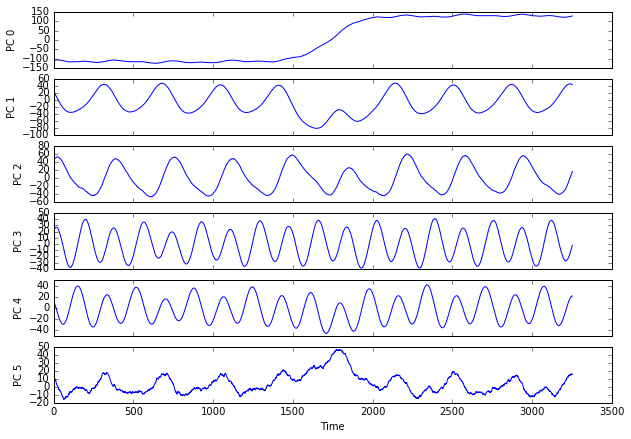

In [9]:
fig,ax = plt.subplots(6, sharex=True,figsize=(10,7) )
for r,i in enumerate(range(6)):
    ax[r].plot(pc[:,i])
    ax[r].set_ylabel('PC ' + str(i))
ax[r].set_xlabel('Time')

So we can see, as expected by the eigenvalues that the first component contains most of the signal. In this case the SSE. However some of that displacement has bled into the other components noticable by the reduced amplitude of the PC related with the annual signal. 

However, this is in terms of lag and the amplitude is meaningless, lets reproject back onto the original time series. 

In [10]:
# R is reconstructed components, RS is summed reconstruction
R,RS = mssa.rc(rho,pc,len(df.columns))

First, lets look at the first channel raw data and see if the summed RC receate the data. 


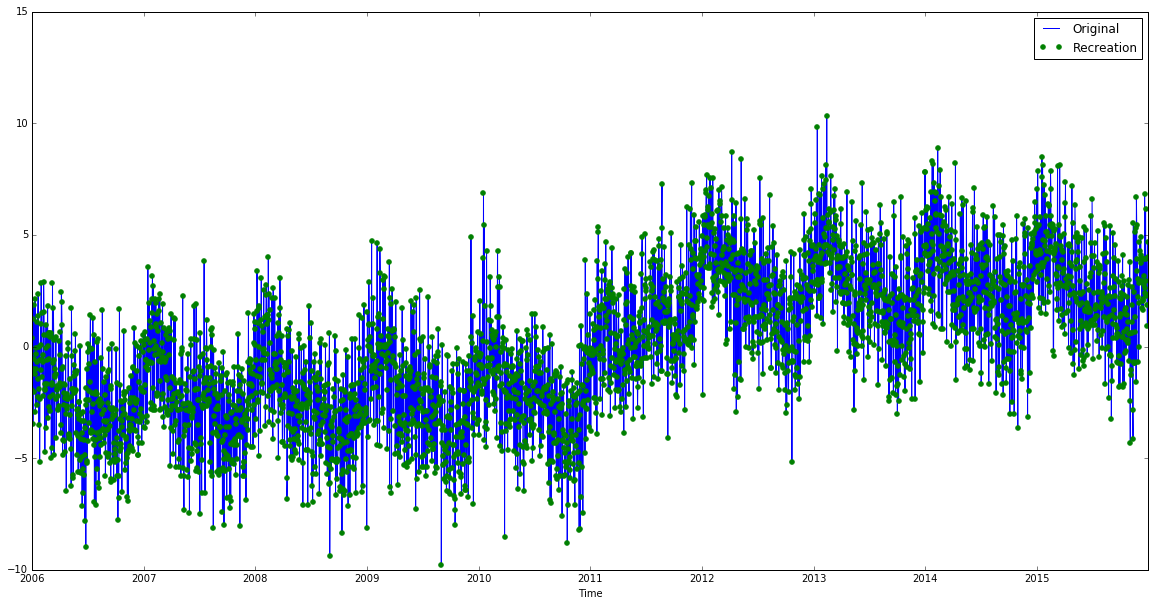

In [11]:
t = [gpsUtils.decimal2datetime(d) for d in times]
plot(t,df[df.columns[0]],label ='Original')
plot(t,RS[:,0],'.',markersize = 10 ,label = 'Recreation')
xlabel('Time')
legend()
f = gcf()
f.set_size_inches(20,10)

So using all the PCs we can recreate the original data perfectly. Lets look at the first 6 components reporjected for the 1st data channel.

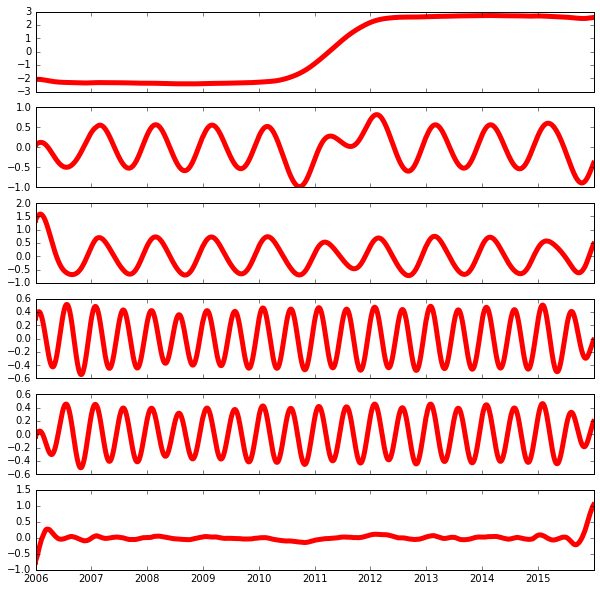

In [12]:
f, ax = plt.subplots(6, sharex=True, figsize=(10,10) )
for i in range(0,6):
    ax[i].plot(t,R[:,i*6],c = 'r',linewidth= 5)

And we can compare the computed PC with the synthetic data. If we compare the 2nd and 3rd componnents with the 
synthetic seasonal signal. 


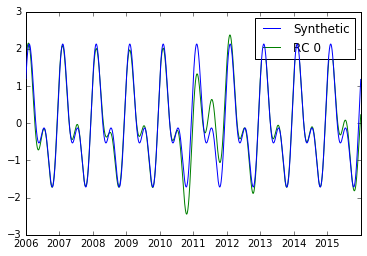

In [13]:
syn = seas #(syn_data.model_tseries(times,funList))
syn = syn
plot(t,syn,label = 'Synthetic',zorder = 100)
r = np.zeros(len(df))
for i in range(1,5):
    r = r + R[:,i*6]
plot(t,r,label = 'RC 0 ')
legend()


So we can recreate the signal, But it misses sum of the annual during the SSE. What about the SSE signal itself. 


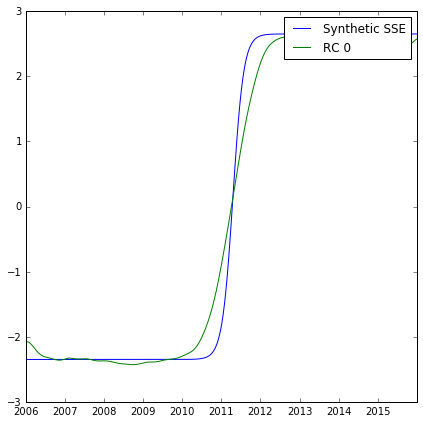

In [14]:
plot(t,sse,label = 'Synthetic SSE')
#plot(t,seas,label = 'Synthetic SEAS')
plot(t,R[:,0],label = 'RC 0 ')

legend()
f = gcf()
f.set_size_inches(7,7)

We can see that it does a reasonable job of matching out syntheic SSE, however the shape is slightly missed. This is becuase of out choise of lag window of 400. The shape of the transients is best preserved if the lag window matches the transients duration. 

### Choice of Lag Window length M 

So how exatly does lag window length effect the results. Some guidlines

1. M must be larger that the longest period which we wish to resolve
2. N/M must should be smaller than ~20 where N is the length of the time series
3. If M is close to the duration of the transient than it will resolve that transient better
4. As M is larger the statistical significance of the PC is less
5. If M is small than a single component can contain mutiple signals

Lets try with a lag of 10 and see what happens:

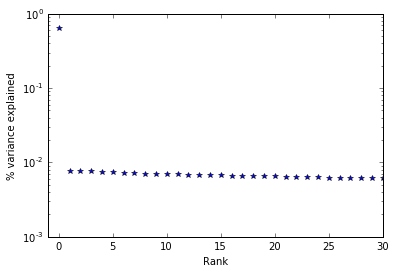

In [15]:
M =10
c = mssa.bk(df,M)
rho,lamb = mssa.get_eigen(c)
plot(lamb/np.sum(lamb),'*')
xlim(-1,30)
xlabel('Rank')
yscale('log')
ylabel('% variance explained')

So with a short time lag we can see that the first eignevalue accounts for all the variance. 

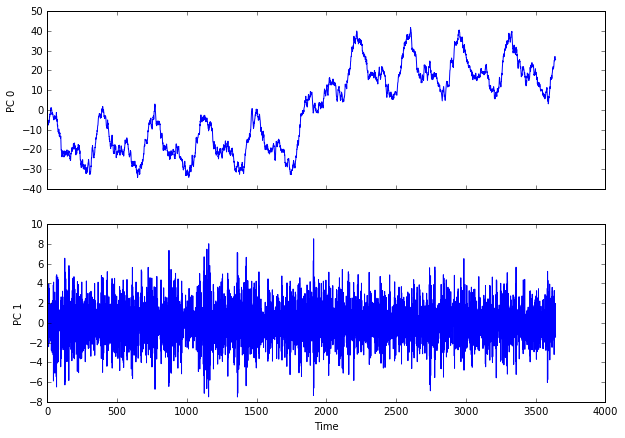

In [16]:
pc = mssa.get_PC(rho,M,df)
fig,ax = plt.subplots(2, sharex=True,figsize=(10,7) )
for r,i in enumerate(range(2)):
    ax[r].plot(pc[:,i])
    ax[r].set_ylabel('PC ' + str(i))
ax[r].set_xlabel('Time')

And with this choice of time winow the first PC also contains some noise. And the second PC is pure noise. 
Finaly lets compare our first PC with the original time series by reprojecting

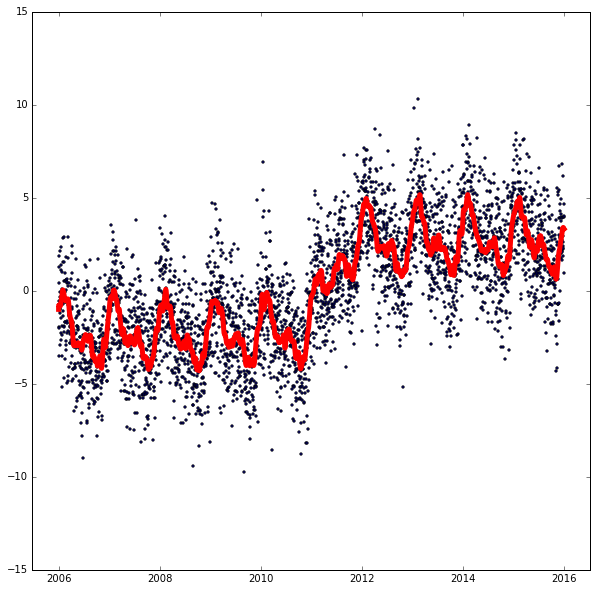

In [17]:
R,RS = mssa.rc(rho,pc,len(df.columns))
f, ax = plt.subplots(1, sharex=True, figsize=(10,10) )
for i in range(1):
    ax.plot(t,R[:,i*6],c = 'r',linewidth= 5)
    ax.scatter(t,df[df.columns[0]],c = 'b',marker = '.')

So what if we go the other way and use a really large time window?

/home/nvoss/tools/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


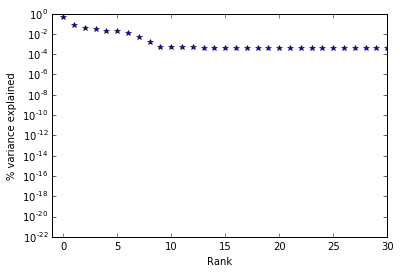

In [18]:
M =1000
c = mssa.bk(df,M)
rho,lamb = mssa.get_eigen(c)
plot(lamb/np.sum(lamb),'*')
xlim(-1,30)
xlabel('Rank')
yscale('log')
ylabel('% variance explained')

So now we can see that we have spread some variance into the higher eigenvalues with M=400 we only needed the first 6 and with M = 1000 we need 9. What does that do to the PC?

/home/nvoss/tools/anaconda/lib/python2.7/site-packages/gpsMSSA-0.1-py2.7.egg/gpsMSSA/mssa.py:135: ComplexWarning: Casting complex values to real discards the imaginary part
  a[:,j]= lfilter(Ej[:,j],1.0,X[:,j],axis = 0 )


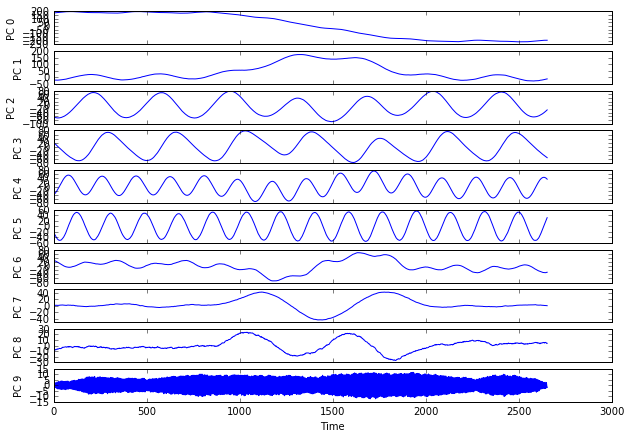

In [19]:
pc = mssa.get_PC(rho,M,df)
fig,ax = plt.subplots(10, sharex=True,figsize=(10,7) )
for r,i in enumerate(range(10)):
    ax[r].plot(pc[:,i])
    ax[r].set_ylabel('PC ' + str(i))
ax[r].set_xlabel('Time')

We can see that some variance related to the SSE signal has been spread on PC0,1,6,7,and 8. So with larger M comes much greater computational burden and reduced ability to seperate signals. However, it appears as ig the seasonal signals are less biased by the SSE so that is a bonus. 

##Presence of colored noise

Here we will analyze how colored noise effects the results of MSSA. We will use the same function with seasonal signals and sse as described before but will introduced $1/f^{\alpha}$ noise with standard devation equal to 2.0. 

Lets start with pink noise where alpha = 1:

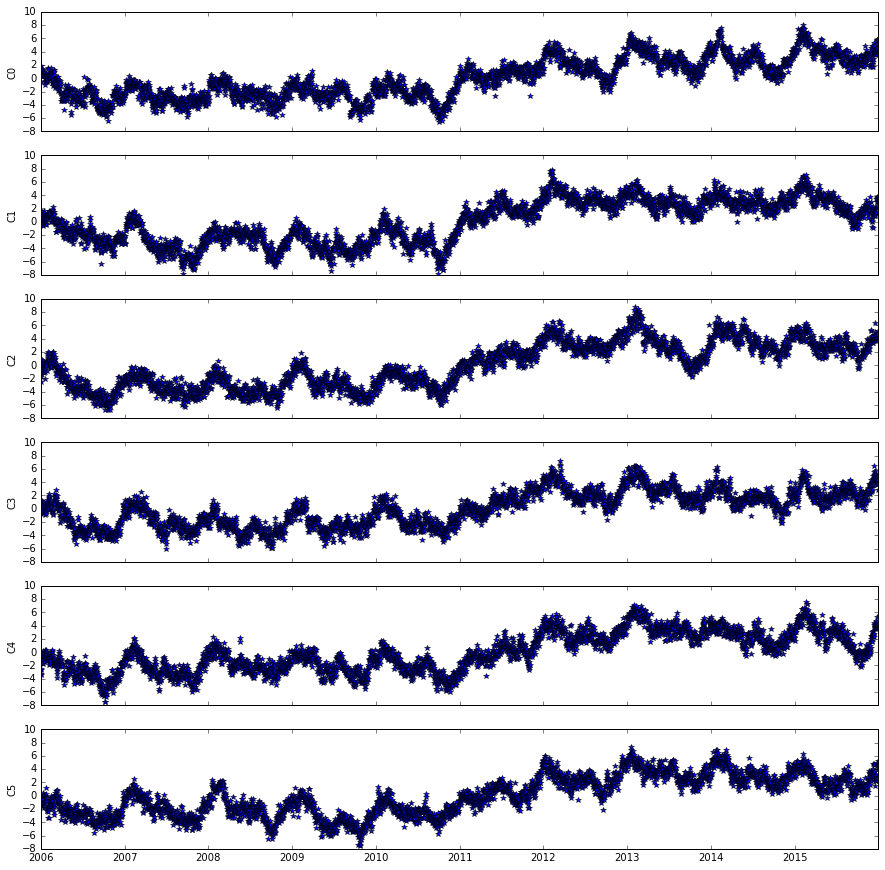

In [20]:
def make_syn_df_2(times,funlist,numChannels,alpha):
    '''
    generate synthetic time series
    '''
    x = syn_data.model_tseries(times,funlist)
    columns = ['C'+str(i) for i in range(numChannels)]
    data = np.zeros((len(times),numChannels))
    for i in range(numChannels):
        noise = syn_data.f_alpha_gaussian(len(times),2.0,alpha)
        data[:,i] = np.add(x,noise)
        data[:,i] = data[:,i]-np.mean(data[:,i])
    df = pd.DataFrame(data,index=times,columns=columns)
    return df
#time series from 2012 to 2016
times = np.arange(2006.0,2016.0,(1/365.25))

fun = 'syn_data.sse' #arctan function
args = [0,2011.3,100.0,5.0] #sse has a midpoint of 2014.0, a duration of 40 days and amplitude of 3
fun2 = 'syn_data.periodAnn'
args2 = [0,0,0.7,1.1]
fun3 = 'syn_data.periodSemiAnn'
args3 = [0,0,0.5,0.8]
funList = []
funList.append(eval(fun)(*args))
funList.append(eval(fun2)(*args2))
funList.append(eval(fun3)(*args3))
sse = syn_data.model_tseries(times,[eval(fun)(*args)])
sse = sse-np.mean(sse)
seas = syn_data.model_tseries(times,[eval(fun2)(*args2),eval(fun3)(*args3)])

df = make_syn_df_2(times,funList,6,1.0) #6 is the number of channels
f, ax = plt.subplots(len(df.columns), sharex=True, sharey=True,figsize=(15,15) )
for i,c in enumerate(df.columns):
    ax[i].plot([gpsUtils.decimal2datetime(d) for d in times],df[c],'*')
    ax[i].set_ylabel(df.columns[i])


So we can see that the presense of pink bouise significantly alters the appearance of the time series. 


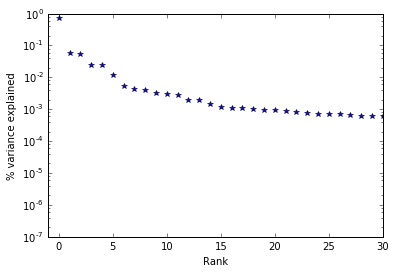

In [21]:
M =400
c = mssa.bk(df,400)
rho,lamb = mssa.get_eigen(c)
plot(lamb/np.sum(lamb),'*')
xlim(-1,30)
xlabel('Rank')
yscale('log')
ylabel('% variance explained')

The pink noise definetely alters the roll off of the eignvalues. However, we can still see two distinct sets of eigenvalue pairs so I think that the seasonal signal will be recovered. Lets look at the PCs. 

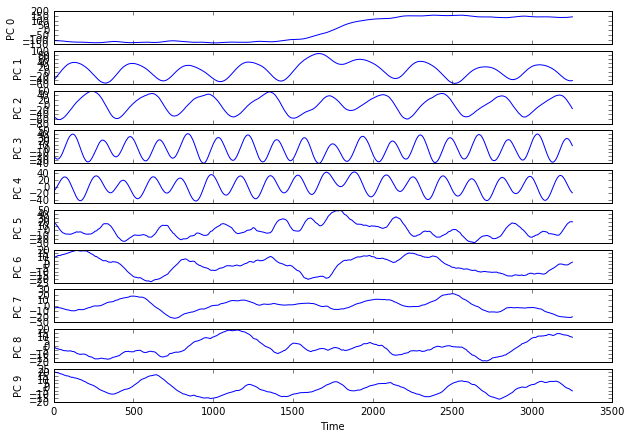

In [22]:
pc = mssa.get_PC(rho,M,df)
fig,ax = plt.subplots(10, sharex=True,figsize=(10,7) )
for r,i in enumerate(range(10)):
    ax[r].plot(pc[:,i])
    ax[r].set_ylabel('PC ' + str(i))
ax[r].set_xlabel('Time')


It appears as if the original signal is well captured by the first 6 PCs. However there is some trend that is in the larger PC that must be generated by the pink (flicker) noise. How well did we match the original signal? 

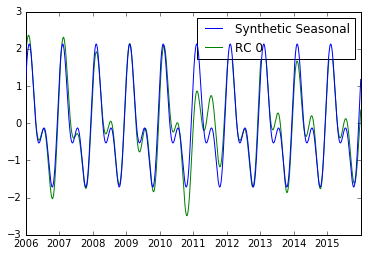

In [23]:
R,RS = mssa.rc(rho,pc,len(df.columns))
syn = seas #(syn_data.model_tseries(times,funList))
syn = syn
plot(t,syn,label = 'Synthetic Seasonal',zorder = 100)
r = np.zeros(len(df))
for i in range(1,5):
    r = r + R[:,i*6]
plot(t,r,label = 'RC 0 ')
legend()

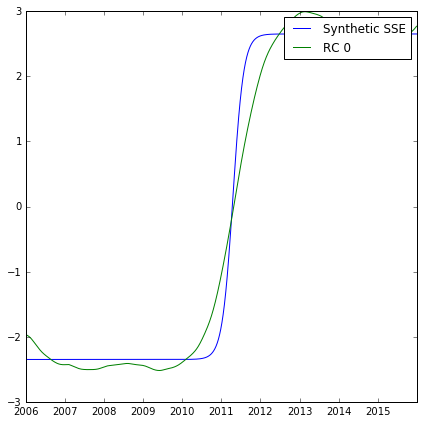

In [24]:
plot(t,sse,label = 'Synthetic SSE')
#plot(t,seas,label = 'Synthetic SEAS')
plot(t,R[:,0],label = 'RC 0 ')

legend()
f = gcf()
f.set_size_inches(7,7)

So performance is still pretty good despite the pink noise. I think the this highlights the advantage of using multiple channels instead of a single channel. What about brown noise (random walk)? We should expect that performance is much worse in this case becuase as Yan and Mattias showed SSE look like random walk. However, the avar code uses a single station. If the signal is coherent across multiple stations is performance better?

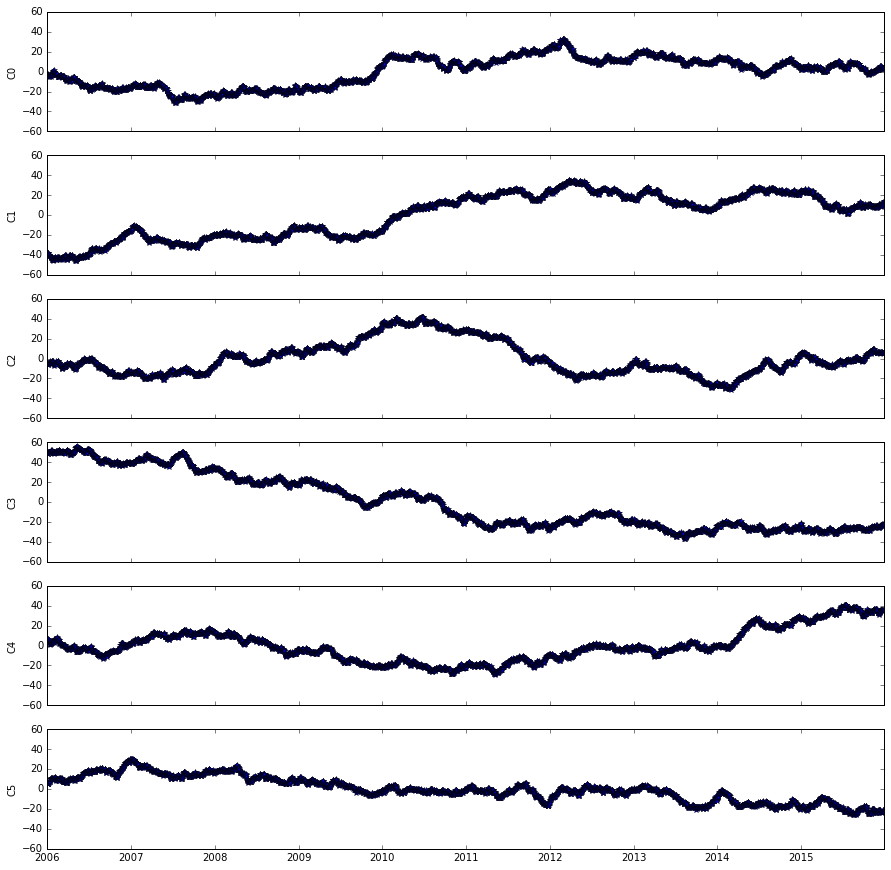

In [25]:
df = make_syn_df_2(times,funList,6,2.0) #6 is the number of channels
f, ax = plt.subplots(len(df.columns), sharex=True, sharey=True,figsize=(15,15) )
for i,c in enumerate(df.columns):
    ax[i].plot([gpsUtils.decimal2datetime(d) for d in times],df[c],'*')
    ax[i].set_ylabel(df.columns[i])

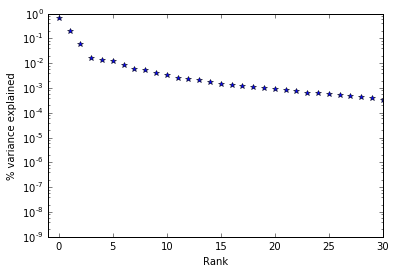

In [26]:
M =400
c = mssa.bk(df,400)
rho,lamb = mssa.get_eigen(c)
plot(lamb/np.sum(lamb),'*')
xlim(-1,30)
xlabel('Rank')
yscale('log')
ylabel('% variance explained')

Not sure if my random walk generator is so good. But we can already see that there is no clear plateu in the eignvalues, and we dont have eigenvalue pairs that are characteristic of the seasonal signal...

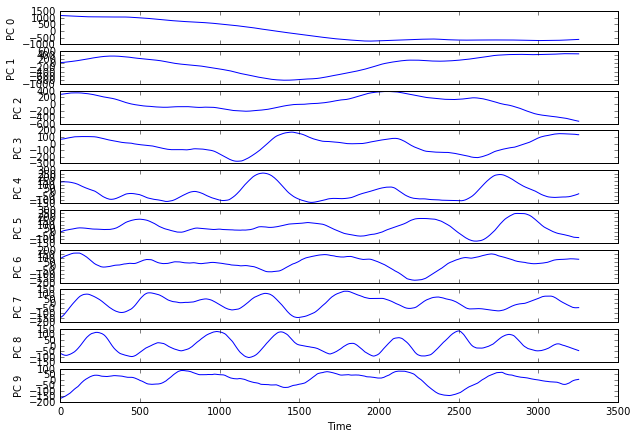

In [27]:
pc = mssa.get_PC(rho,M,df)
fig,ax = plt.subplots(10, sharex=True,figsize=(10,7) )
for r,i in enumerate(range(10)):
    ax[r].plot(pc[:,i])
    ax[r].set_ylabel('PC ' + str(i))
ax[r].set_xlabel('Time')

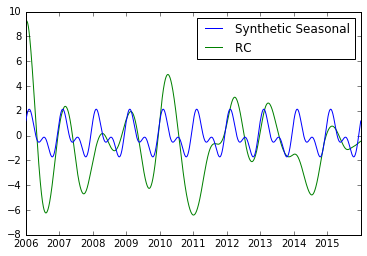

In [28]:
R,RS = mssa.rc(rho,pc,len(df.columns))
syn = seas #(syn_data.model_tseries(times,funList))
syn = syn
plot(t,syn,label = 'Synthetic Seasonal',zorder = 100)
r = np.zeros(len(df))
for i in range(5,9):
    r = r + R[:,i*6]
plot(t,r,label = 'RC ')
legend()

I can not find a combination of PC that is clearly related to the seasonal signal.

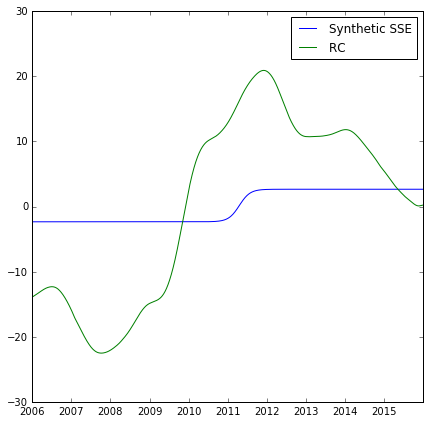

In [29]:
plot(t,sse,label = 'Synthetic SSE')
#plot(t,seas,label = 'Synthetic SEAS')
r = np.zeros(len(df))
for i in range(0,5):
    r = r + R[:,i*6]
plot(t,r,label = 'RC ')
legend()
f = gcf()
f.set_size_inches(7,7)

The amplitude of the random walk is probably way to large for this test compared to the underlying sse signal. Not sure...

## Repeating Transients (SSE)

What about if the transients repeat with constant interval? 

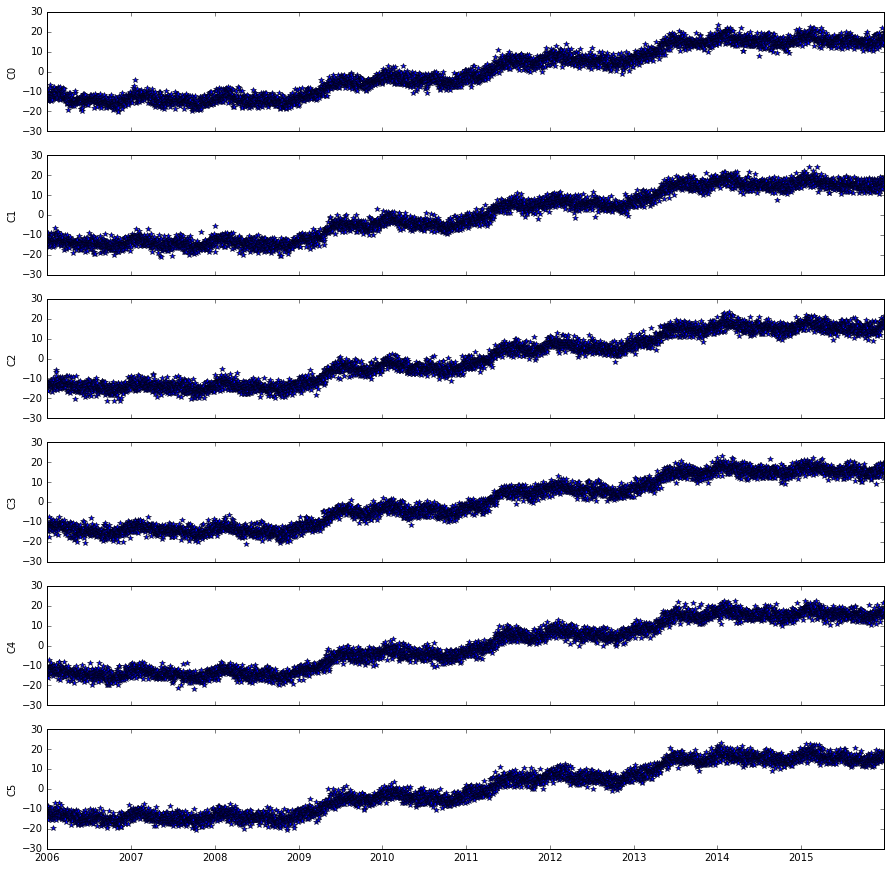

In [30]:
fun = 'syn_data.sse' #arctan function
args = [0,2011.3,40.0,10.0] #sse has a midpoint of 2014.0, a duration of 40 days and amplitude of 3
fun2 = 'syn_data.periodAnn'
args2 = [0,0,0.7,1.1]
fun3 = 'syn_data.periodSemiAnn'
args3 = [0,0,0.5,0.8]
funList = []
funList.append(eval(fun)(*args))
funList.append(eval(fun2)(*args2))
funList.append(eval(fun3)(*args3))
sse = syn_data.model_tseries(times,[eval(fun)(*args)])
sse = sse-np.mean(sse)
seas = syn_data.model_tseries(times,[eval(fun2)(*args2),eval(fun3)(*args3)])
fun4 = 'syn_data.sse' #arctan function
args4 = [0,2009.3,40.0,10.0]
fun5 = 'syn_data.sse' #arctan function
args5 = [0,2013.3,40.0,10.0]
funList.append(eval(fun4)(*args4))
funList.append(eval(fun5)(*args5))
df = make_syn_df(times,funList,6) #6 is the number of channels
f, ax = plt.subplots(len(df.columns), sharex=True, sharey=True,figsize=(15,15) )
for i,c in enumerate(df.columns):
    ax[i].plot([gpsUtils.decimal2datetime(d) for d in times],df[c],'*')
    ax[i].set_ylabel(df.columns[i])

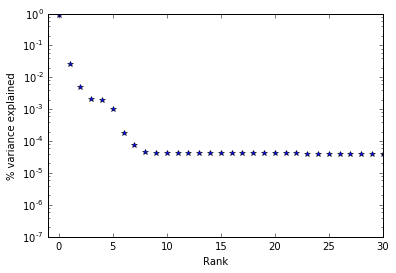

In [31]:
M =400
c = mssa.bk(df,400)
rho,lamb = mssa.get_eigen(c)

plot(lamb/np.sum(lamb),'*')
xlim(-1,30)
xlabel('Rank')
yscale('log')
ylabel('% variance explained')

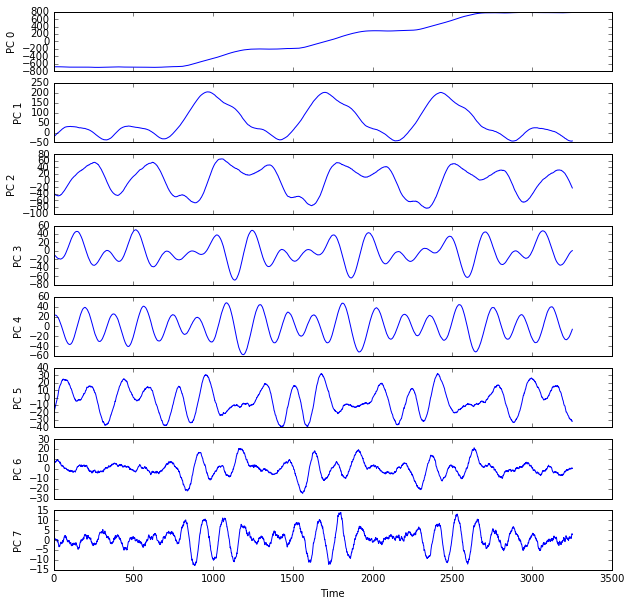

In [32]:
pc = mssa.get_PC(rho,M,df)
fig,ax = plt.subplots(8, sharex=True,figsize=(10,10) )
for r,i in enumerate(range(8)):
    ax[r].plot(pc[:,i])
    ax[r].set_ylabel('PC ' + str(i))
ax[r].set_xlabel('Time')


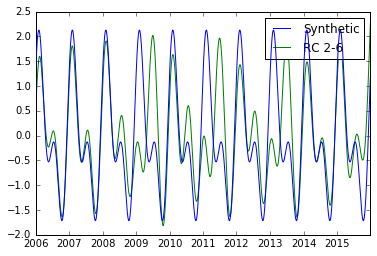

In [33]:
R,RS = mssa.rc(rho,pc,len(df.columns))
syn = seas #(syn_data.model_tseries(times,funList))
syn = syn
plot(t,syn,label = 'Synthetic',zorder = 100)
r = np.zeros(len(df))
for i in range(2,6):
    r = r + R[:,i*6]
plot(t,r,label = 'RC 2-6')
legend()


So the fit is good except during the timed of SSE when it apears to miss the semi-annual signal. 

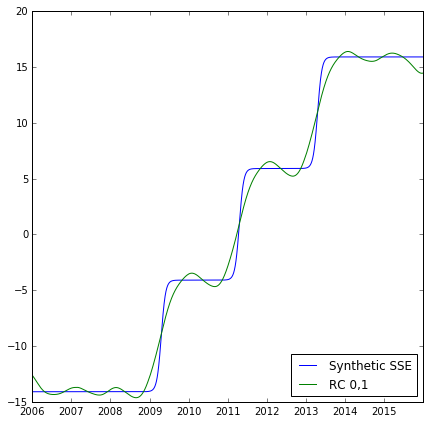

In [34]:
sse = syn_data.model_tseries(times,[eval(fun)(*args),eval(fun4)(*args4),eval(fun5)(*args5)])
sse = sse-np.mean(sse)
plot(t,sse,label = 'Synthetic SSE')
#plot(t,seas,label = 'Synthetic SEAS')
r = np.zeros(len(df))
for i in range(2):
   r = r + R[:,i*6]
plot(t,r,label = 'RC 0,1 ') 
legend(loc = 4)
f = gcf()
f.set_size_inches(7,7)

So there is some seasonal signal alliased on top of the SSE signal, but the amplitude is actually well matched. 

## Seasonal Signal with variable amplitude

Here we will look at what happends when the seasonal signal has variable amplitude. 

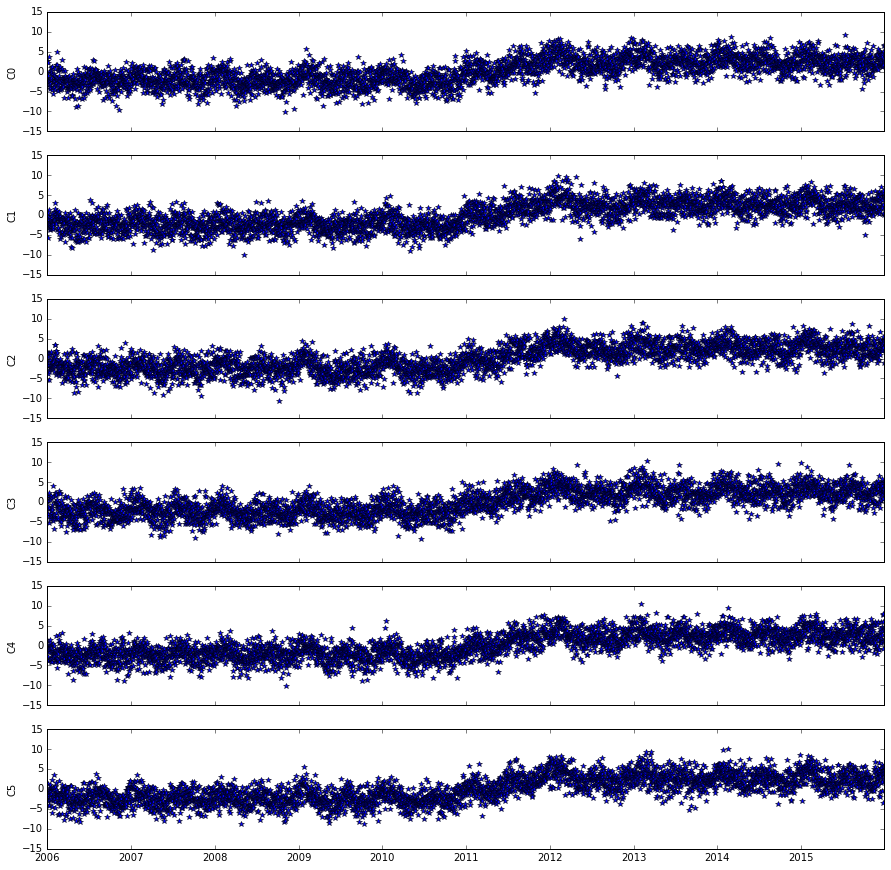

In [35]:
def make_syn_df_3(x,times,funlist,numChannels):
    '''
    generate synthetic time series
    '''
    #x = syn_data.model_tseries(times,funlist)
    columns = ['C'+str(i) for i in range(numChannels)]
    data = np.zeros((len(times),numChannels))
    for i in range(numChannels):
        noise = np.random.normal(0,2,len(times))
        data[:,i] = np.add(x,noise)
        data[:,i] = data[:,i]-np.mean(data[:,i])
    df = pd.DataFrame(data,index=times,columns=columns)
    return df
fun = 'syn_data.sse' #arctan function
args = [0,2011.3,100.0,5.0] #sse has a midpoint of 2014.0, a duration of 40 days and amplitude of 3
fun2 = 'syn_data.periodAnnVar'
args2 = [0,0,0.7,1.1]
fun3 = 'syn_data.periodSemiAnn'
args3 = [0,0,0.5,0.8]
funList.append(eval(fun)(*args))
funList.append(eval(fun2)(*args2))
funList.append(eval(fun3)(*args3))
sse = syn_data.model_tseries(times,[eval(fun)(*args)])
sse = sse-np.mean(sse)
seas = syn_data.model_tseries(times,[eval(fun2)(*args2),eval(fun3)(*args3)])

df = make_syn_df_3((sse+seas),times,funList,6) #6 is the number of channels
f, ax = plt.subplots(len(df.columns), sharex=True, sharey=True,figsize=(15,15) )
for i,c in enumerate(df.columns):
    ax[i].plot([gpsUtils.decimal2datetime(d) for d in times],df[c],'*')
    ax[i].set_ylabel(df.columns[i])

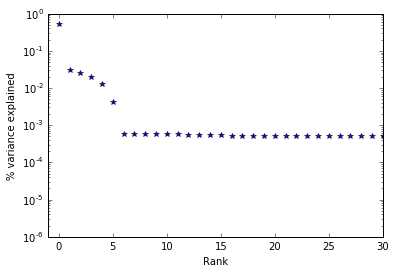

In [36]:
M =400
c = mssa.bk(df,400)
rho,lamb = mssa.get_eigen(c)
plot(lamb/np.sum(lamb),'*')
xlim(-1,30)
xlabel('Rank')
yscale('log')
ylabel('% variance explained')

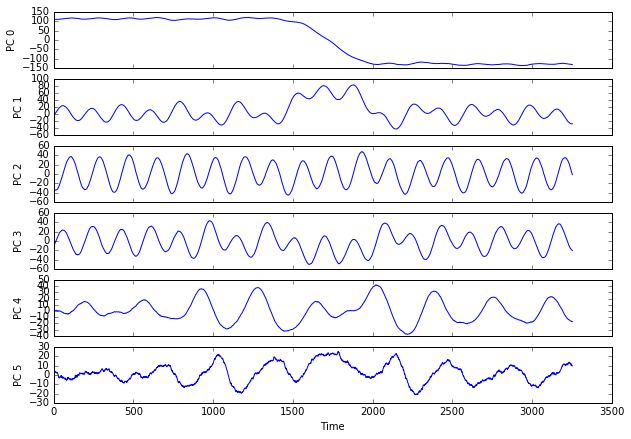

In [37]:
pc = mssa.get_PC(rho,M,df)
fig,ax = plt.subplots(6, sharex=True,figsize=(10,7) )
for r,i in enumerate(range(6)):
    ax[r].plot(pc[:,i])
    ax[r].set_ylabel('PC ' + str(i))
ax[r].set_xlabel('Time')

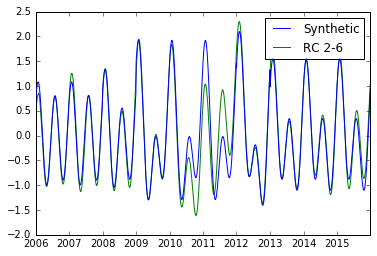

In [38]:
t = [gpsUtils.decimal2datetime(d) for d in times]
R,RS = mssa.rc(rho,pc,len(df.columns))
syn = seas 
plot(t,syn,label = 'Synthetic',zorder = 100)
r = np.zeros(len(df))
for i in range(1,6):
    r = r + R[:,i*6]
plot(t,r,label = 'RC 2-6')
legend()

So it is able to match a non fixed amplitude seasonal signal. But there is still misfit when the transient is going on. 

###Real Data Test

Telica Volcano, we are going to dopwnsample to a sample very 4 days in order to speed it up a bit. 

df = mssa.create_network_matrix('telica',2010.0,2015.0)
df = df.resample('4d',how = 'mean')

Here we plot the data from the stations, this network could benifit greatly from some cleaning of outliers. 

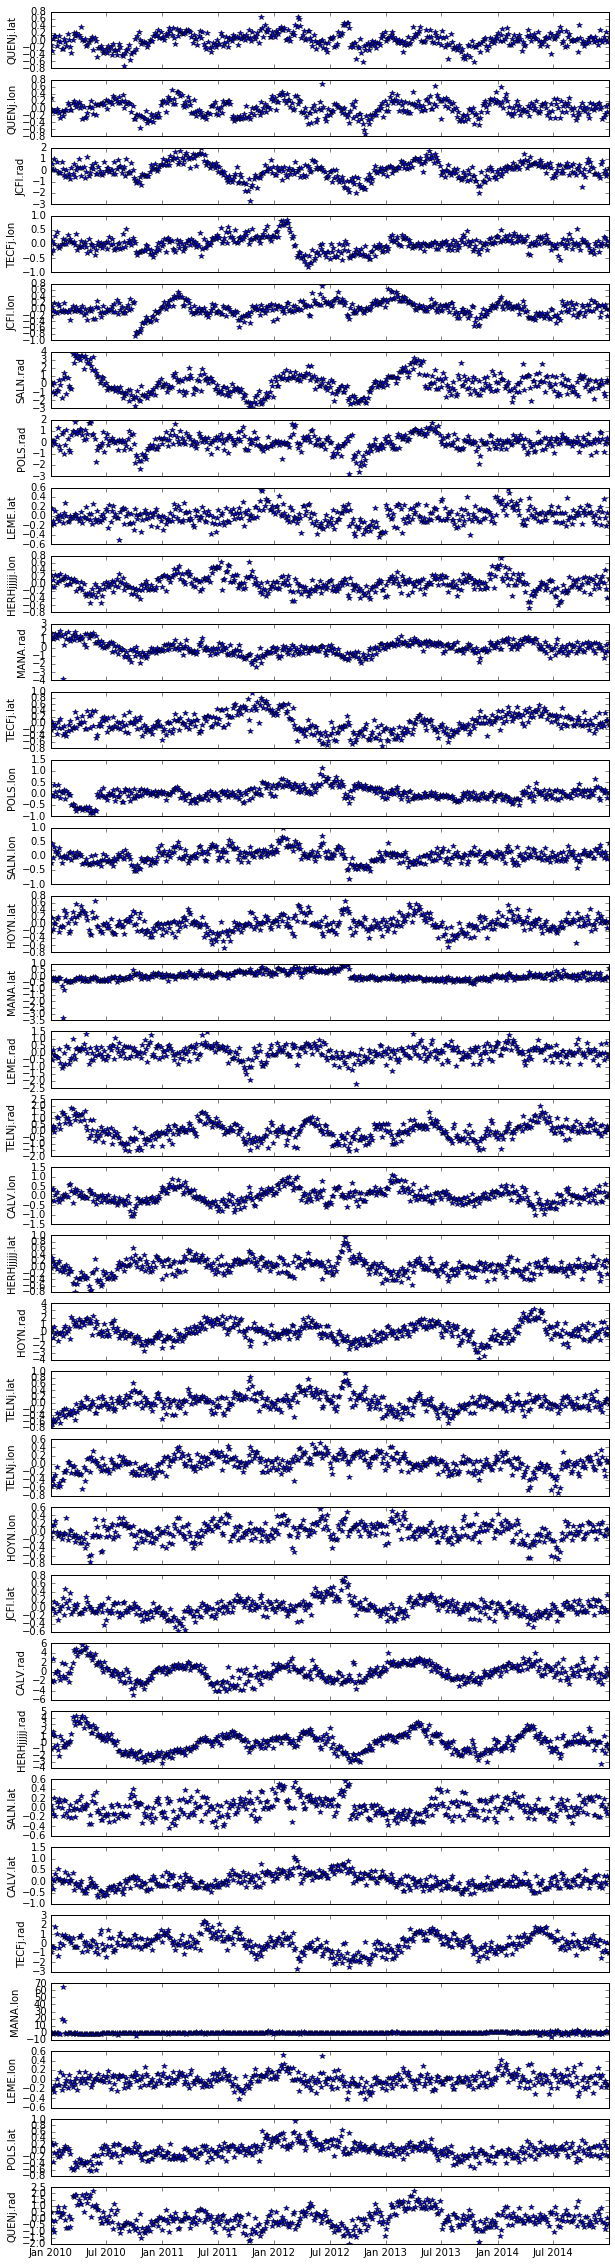

In [56]:
f, ax = plt.subplots(len(df.columns), sharex=True, figsize= (10,40))
for i,c in enumerate(df.columns):
    ax[i].plot(df.index,df[c],'*')
    ax[i].set_ylabel(df.columns[i])

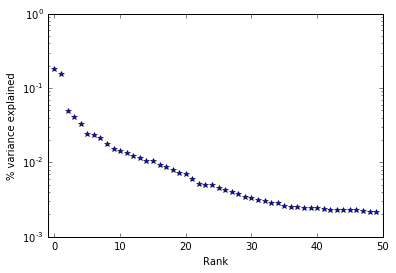

In [67]:
M =100 # a 10*4 day window is equivelent to our previous use of 400 daysdue to our downsamplling 
c = mssa.bk(df,M)
rho,lamb = mssa.get_eigen(c)
plot(lamb[0:50]/np.sum(lamb),'*')
xlim(-1,50)
xlabel('Rank')
yscale('log')
ylabel('% variance explained')

The first two eignvalue pairs are matched as "sin" and "cosine" and thus related to the seasonal signal, which we can see below when we plot the first 6 PCs

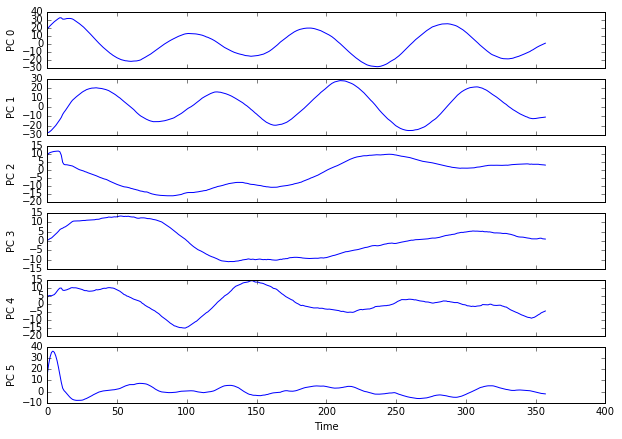

In [69]:
pc = mssa.get_PC(rho,M,df)
fig,ax = plt.subplots(6, sharex=True,figsize=(10,7) )
for r,i in enumerate(range(6)):
    ax[r].plot(pc[:,i])
    ax[r].set_ylabel('PC ' + str(i))
ax[r].set_xlabel('Time')

Does a transient appear if we remove the seasonal signal?

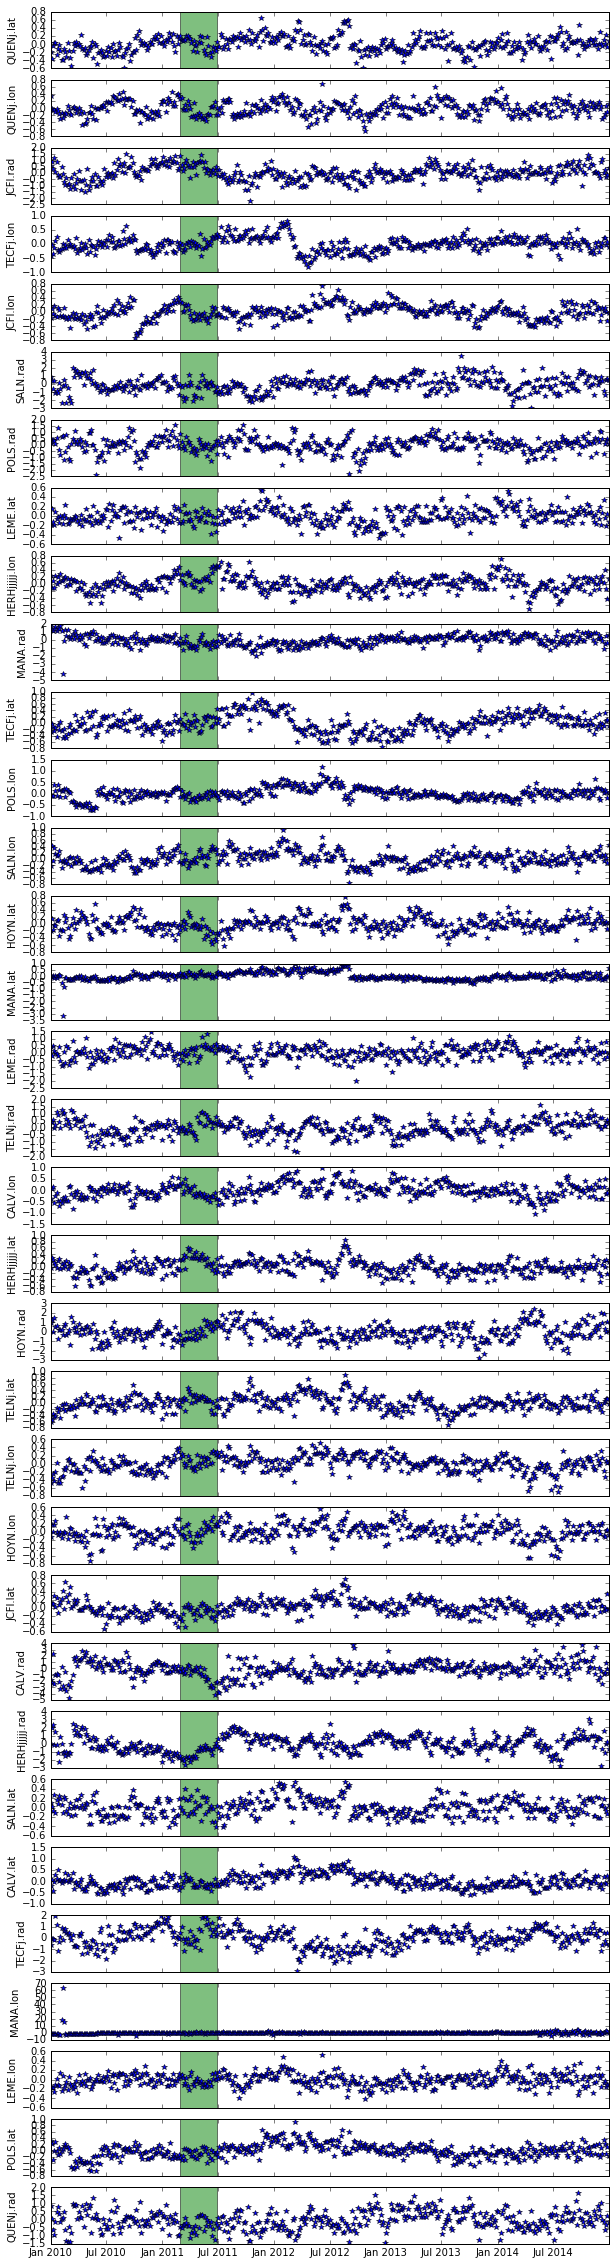

In [74]:
R,RS = mssa.rc(rho,pc,len(df.columns))
f, ax = plt.subplots(len(df.columns), sharex=True, figsize= (10,40))
for i,c in enumerate(df.columns):
    ax[i].plot(df.index,df[c]-R[:,0*len(df.columns)+i]-R[:,1*len(df.columns)+i],'*')
    ax[i].set_ylabel(df.columns[i])
    ax[i].axvspan(pd.to_datetime("2011-3-01"),pd.to_datetime("2011-06-29"), facecolor='g', alpha=0.5)
#scatter(df.index,df[df.columns[0]],label = df.columns[0],zorder = 100)
#r = np.zeros(len(df))
#for i in range(0,6):
   # r = r + R[:,i*len(df.columns)]
#plot(df.index,r,label = 'RC 2-6')
#legend()

It might deserve further analysis?